 # 1. POSMS: DIAGNOZE (Plānošana)

1. Biznesa jautājums:
"Kāpēc, pieaugot kopējiem ieņēmumiem, vienlaikus būtiski pieaug klientu sūdzību un naudas atgriešanas apjoms, un kuri konkrēti produkti vai reģioni rada šo negatīvo peļņas ietekmi?"

2. Hipotēzes (minējumi):

Hipotēze Nr. 1: Uzņēmums ir uzsācis pārdot jaunu produktu kategoriju, kurai ir zema kvalitāte (brāķis), kas izraisa masveida naudas atgriešanas.

Hipotēze Nr. 2: Pārdošanas nodaļa izmanto agresīvas mārketinga kampaņas, kas rada nepatiesas ekspektācijas, tādēļ klienti pēc preces saņemšanas ir vīlušies un raksta sūdzības.

3. Pārbaudes (ko mēs darīsim):

Aprēķināšu atgriešanas koeficientu (Return Rate) katram produktam un salīdzināšu to ar ieņēmumiem.

Analizēšu klientu sūdzību tekstu, lai atrastu biežākos atslēgvārdus (piemēram, "salūza", "nestrādā", "krāsa neatbilst").

Pārbaudīšu, vai sūdzību skaitam ir izteikta saikne ar kādu konkrētu laika periodu (piemēram, pēc lielas izpārdošanas).

4. Rīcības slieksnis:
"Ja kāda produkta atgriešanas īpatsvars pārsniedz 12% no tā pārdošanas apjoma vai ja negatīvo sūdzību skaits par konkrētu modeli pārsniedz 20 gabalus nedēļā, es ieteikšu nekavējoties apturēt šī produkta tirdzniecību līdz turpmākai izmeklēšanai."

# 2. POSMS: Datu ielāde un tīrīšana

1. PROMPT: 1. daļa: Pasūtījumi.
Sāksim ar pirmo failu — orders_raw.csv. Tajā cenas un datumi ir dažādos formātos, tāpēc mums tie ir jāunificē.

In [2]:
import pandas as pd
import numpy as np

# 1. Ielādējam datus
orders = pd.read_csv('orders_raw.csv')

print("--- Pārbaude PIRMS tīrīšanas ---")
# Apskatām pirmās rindas un kolonnu nosaukumus
print(orders.head())

# 2. Datumu normalizācija (Tavam failam kolonna ir 'Date')
orders['Date'] = pd.to_datetime(orders['Date'], dayfirst=True, errors='coerce')

# 3. Cenu normalizācija (Tavam failam kolonna ir 'Price')
# Noņemam valūtu simbolus un atstarpes, tad pārvēršam par skaitli
orders['Price'] = orders['Price'].astype(str).str.replace(r'[\$|EUR|,]', '', regex=True)
orders['Price'] = pd.to_numeric(orders['Price'], errors='coerce')

# 4. Aprēķinām kopējo ieņēmumu katrai rindai (Price * Quantity)
orders['Revenue'] = orders['Price'] * orders['Quantity']

# 5. Tukšo vērtību apstrāde
# Izmetam tikai tās rindas, kur nav cenas vai ID
orders = orders.dropna(subset=['Price', 'Transaction_ID'])

print("\n--- Pārbaude PĒC tīrīšanas ---")
print(orders.head())
print(f"Rindu skaits pēc tīrīšanas: {len(orders)}")

--- Pārbaude PIRMS tīrīšanas ---
   Transaction_ID        Date Customer_ID Product_Category  Product_Name  \
0          100236  2023-11-24       C0012      Electronics  Smartphone Z   
1          100061  2023-11-17       C0002      Electronics      Laptop X   
2          101131  2023-12-14       C0008       Smart Home      NordPlug   
3          100391  28/11/2023       C0001       Smart Home     NordTherm   
4          100319  2023-11-27       C0004      Accessories    Phone Case   

         Price  Quantity Payment_Status  
0       919.20         1           Paid  
1  1598,23 EUR         1           Paid  
2        23.86         1           Paid  
3      $101.68         1           Paid  
4    35,72 EUR         1           Paid  

--- Pārbaude PĒC tīrīšanas ---
   Transaction_ID       Date Customer_ID Product_Category  Product_Name  \
0          100236 2023-11-24       C0012      Electronics  Smartphone Z   
1          100061 2023-11-17       C0002      Electronics      Laptop X   
2

/tmp/ipython-input-826759079.py:12: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  orders['Date'] = pd.to_datetime(orders['Date'], dayfirst=True, errors='coerce')


2. PROMPT: 2. daļa: Atgriezumu apstrāde (returns_messy.xlsx)
Pasūtījuma ID nav atsevišķā kolonnā, bet gan noslēpts tekstā. Mums tie ir jāizvelk ārā.

In [4]:
import re

# 1. Ielādējam Excel failu
returns = pd.read_excel('returns_messy.xlsx')

print("--- Atgriezumu dati PIRMS tīrīšanas ---")
print(returns.head())

# 2. Funkcija ID izvilkšanai
def extract_id(text):
    text = str(text)
    # Meklējam 6 ciparus (tavā failā pēc 'Ref:' vai 'Order')
    match = re.search(r'(\d{6})', text)
    return int(match.group(1)) if match else np.nan

# 3. Pielietojam kolonai 'Original_Tx_ID'
returns['Transaction_ID'] = returns['Original_Tx_ID'].apply(extract_id)

# 4. Normalizējam Refund_Amount (ja tur ir komati vai valūtas)
returns['Refund_Amount'] = returns['Refund_Amount'].astype(str).str.replace(',', '.')
returns['Refund_Amount'] = pd.to_numeric(returns['Refund_Amount'], errors='coerce').fillna(0)

# 5. Izmetam rindas, kur nav ID, un pārvēršam ID par veselu skaitli
returns = returns.dropna(subset=['Transaction_ID'])
returns['Transaction_ID'] = returns['Transaction_ID'].astype(int)

print("\n--- Atgriezumu dati PĒC ID izvilkšanas ---")
print(returns[['Transaction_ID', 'Refund_Amount']].head())

# 6. SAVIENOŠANA ar galveno orders tabulu
# Pievienojam Refund_Amount pie df_combined
df_combined = pd.merge(orders, returns[['Transaction_ID', 'Refund_Amount']], on='Transaction_ID', how='left')

# Ja prece nav atgriezta, atgriezuma summa ir 0
df_combined['Refund_Amount'] = df_combined['Refund_Amount'].fillna(0)

# 7. Aprēķinām TĪRO PEĻŅU (Revenue mīnus Refund_Amount)
# (Pieņemot, ka uzņēmumam peļņa ir Revenue, bet atgriezumi to samazina)
df_combined['Net_Revenue'] = df_combined['Revenue'] - df_combined['Refund_Amount']

print("\n✅ Dati veiksmīgi savienoti!")
print(f"Kopējais rindu skaits: {len(df_combined)}")
print(df_combined[['Transaction_ID', 'Revenue', 'Refund_Amount', 'Net_Revenue']].head())

--- Atgriezumu dati PIRMS tīrīšanas ---
  Return_ID Original_Tx_ID Return_Date  Refund_Amount     Status
0   R000006    Ref: 100577  2023-12-12         427.00  Processed
1   R000016    Ref: 100262  2023-12-02            NaN  Processed
2   R000033    Ref: 100374  2023-12-04         798.57  Processed
3   R000041    Ref: 101165  2023-12-20          10.75   Rejected
4   R000038    Ref: 100750  2023-12-12         380.90  Processed

--- Atgriezumu dati PĒC ID izvilkšanas ---
   Transaction_ID  Refund_Amount
0          100577         427.00
1          100262           0.00
2          100374         798.57
3          101165          10.75
4          100750         380.90

✅ Dati veiksmīgi savienoti!
Kopējais rindu skaits: 1181
   Transaction_ID    Revenue  Refund_Amount  Net_Revenue
0          100236     919.20            0.0       919.20
1          100061  159823.00            0.0    159823.00
2          101131      23.86            0.0        23.86
3          100391     101.68            0.0

3. PROMPT: 3. posms: Sūdzību apstrāde (customer_tickets.jsonl)
 Mums ir fails, kurā katra rinda ir JSON objekts ar klientu sūdzībām. Sūdzību teksts satur HTML tagus un ir haotisks. Tavs uzdevums ir sakārtot šo failu darbam atblstoši uzdevuma mērķim.

In [6]:
import json
import pandas as pd
import re
import numpy as np

# 1. Ielādējam JSONL failu
tickets_data = []
with open('customer_tickets.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        tickets_data.append(json.loads(line))

tickets = pd.DataFrame(tickets_data)

print("--- Sūdzību dati PIRMS tīrīšanas ---")
print(tickets.head())

# 2. Teksta tīrīšana (noņemam HTML tagus kā <p>, <br> un \n simbolus)
def clean_text(text):
    if not isinstance(text, str): return ""
    # Noņem HTML tagus
    text = re.sub(r'<[^>]+>', '', text)
    # Noņem jaunas rindas simbolus un liekas atstarpes
    text = text.replace('\n', ' ').replace('\r', '')
    return " ".join(text.split())

# Lietojam 'Message_Body', jo tā saucas tava kolonna!
tickets['Clean_Ticket'] = tickets['Message_Body'].apply(clean_text)

# 3. Kategorizēšana latviski (balstoties uz tavu sūdzību saturu)
def categorize_complaint(row):
    # Skatāmies gan tēmu, gan pašu tekstu
    combined_text = (str(row['Subject']) + " " + str(row['Clean_Ticket'])).lower()

    if any(x in combined_text for x in ['refund', 'naudu', 'atgriezt', 'atmaksa']):
        return 'Naudas atgriešana'
    if any(x in combined_text for x in ['broken', 'nestrādā', 'defekt', 'salūza', 'pairing', 'connect']):
        return 'Kvalitātes problēmas'
    if any(x in combined_text for x in ['delivery', 'piegāde', 'kavējas', 'order', 'kurjers']):
        return 'Piegādes jautājumi'
    return 'Citi jautājumi'

tickets['Complaint_Category'] = tickets.apply(categorize_complaint, axis=1)

print("\n--- Sūdzību dati PĒC apstrādes ---")
print(tickets[['Complaint_Category', 'Clean_Ticket']].head())

# 4. SAGLABĀŠANA
# Saglabājam datus, lai app.py tos varētu nolasīt
df_combined.to_csv('enriched_data.csv', index=False)
tickets.to_csv('tickets_cleaned.csv', index=False)

print("\n✅ Viss gatavs! Fails 'tickets_cleaned.csv' ir izveidots.")

--- Sūdzību dati PIRMS tīrīšanas ---
  Ticket_ID Date_Logged Customer_ID                     Subject  \
0   T000201  2023-12-12       C0047     Not working as expected   
1   T000007  2023-11-21       C0030          Where is my order?   
2   T000288  2023-12-18       C0237       Locked out of my home   
3   T000150  2023-12-09       C0122             I want a refund   
4   T000063  2023-11-29       C0004  NordLock Pro pairing issue   

                                        Message_Body  
0  <p>The product is defective.\nVery disappointe...  
1  My delivery is stuck.<br>Tracking shows in tra...  
2  I am locked out — the lock does not respond.\n...  
3  I want to get a refund for this product.<br>It...  
4  The app will not connect to WiFi.\nI tried res...  

--- Sūdzību dati PĒC apstrādes ---
     Complaint_Category                                       Clean_Ticket
0    Piegādes jautājumi  The product is defective. Very disappointed. W...
1    Piegādes jautājumi  My delivery is stuc

# 4. POSMS: Analīze (Grafiki)

4. PROMPT: Izveido man 3 grafikus no tiem datiem, ko mēs tikko sagatavojām. Man vajag redzēt:

Kā mainās nauda un atgriešana pa nedēļām.

No kuriem 5 produktiem ir visvairāk atgrieztās naudas.

Par ko cilvēki visvairāk sūdzas (tās kategorijas, ko mēs uztaisījām).
Un beigās uzraksti man, kurš ir sliktākais produkts.

/tmp/ipython-input-3740142308.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bad_products.values, y=bad_products.index, palette='Reds_r')


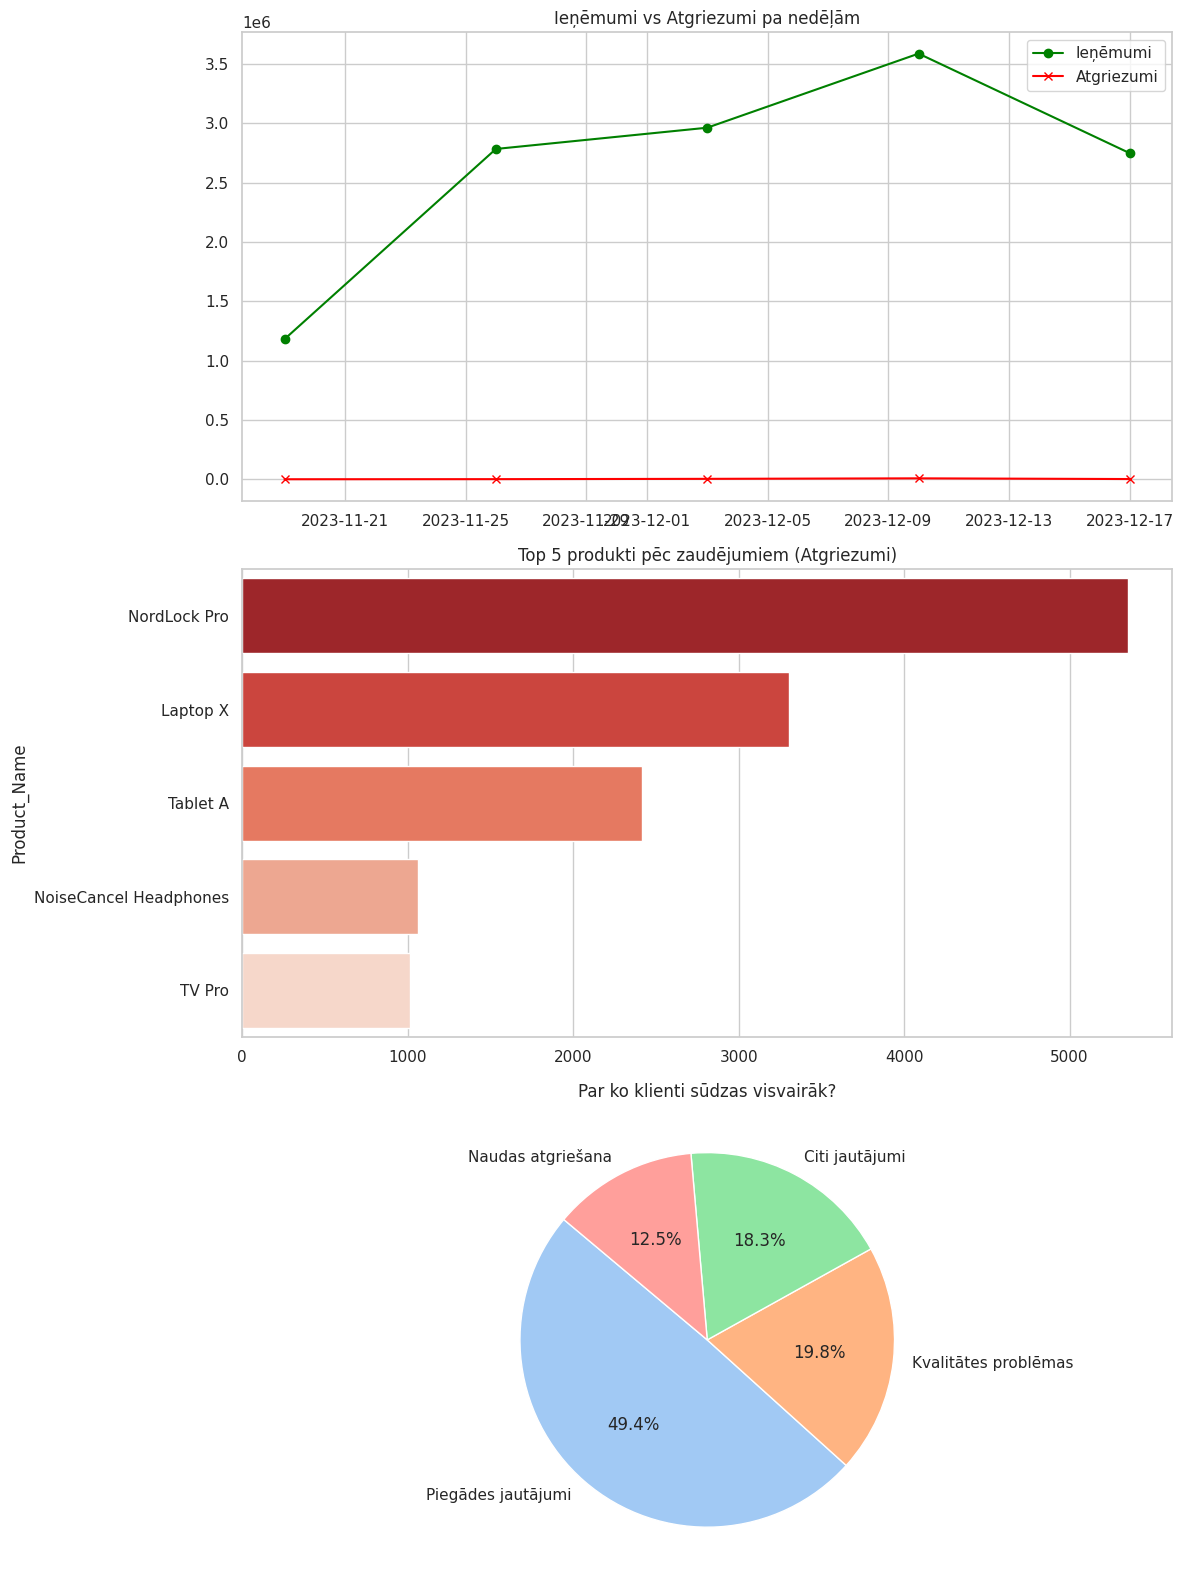


--- 🕵️ ANALĪTIĶA ZIŅOJUMS ---
Sliktākais produkts ir: NordLock Pro
Galvenais sūdzību iemesls: Piegādes jautājumi


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iestatām vizuālo stilu
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 16))

# 1. GRAFIKS: Tendence laikā
plt.subplot(3, 1, 1)
monthly_data = df_combined.resample('W', on='Date')[['Revenue', 'Refund_Amount']].sum()
plt.plot(monthly_data.index, monthly_data['Revenue'], label='Ieņēmumi', color='green', marker='o')
plt.plot(monthly_data.index, monthly_data['Refund_Amount'], label='Atgriezumi', color='red', marker='x')
plt.title('Ieņēmumi vs Atgriezumi pa nedēļām')
plt.legend()

# 2. GRAFIKS: Sliktākie produkti
plt.subplot(3, 1, 2)
bad_products = df_combined.groupby('Product_Name')['Refund_Amount'].sum().sort_values(ascending=False).head(5)
sns.barplot(x=bad_products.values, y=bad_products.index, palette='Reds_r')
plt.title('Top 5 produkti pēc zaudējumiem (Atgriezumi)')

# 3. GRAFIKS: Sūdzību sadalījums
plt.subplot(3, 1, 3)
ticket_counts = tickets['Complaint_Category'].value_counts()
plt.pie(ticket_counts, labels=ticket_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Par ko klienti sūdzas visvairāk?')

plt.tight_layout()
plt.show()

# SECINĀJUMS
worst_prod = bad_products.index[0]
print(f"\n--- 🕵️ ANALĪTIĶA ZIŅOJUMS ---")
print(f"Sliktākais produkts ir: {worst_prod}")
print(f"Galvenais sūdzību iemesls: {ticket_counts.idxmax()}")

5. PROMPT: Uztaisi tos pašus 3 grafikus, bet sakārto vizuālo pusi prezentācijai: pagriez datumus, lai tie neprklājas, pievieno lielākas atstarpes ap grafikiem, lai rāmji nepiekļaitos asīm, un noapaļo līknes, lai tās izskatītos modernāk.

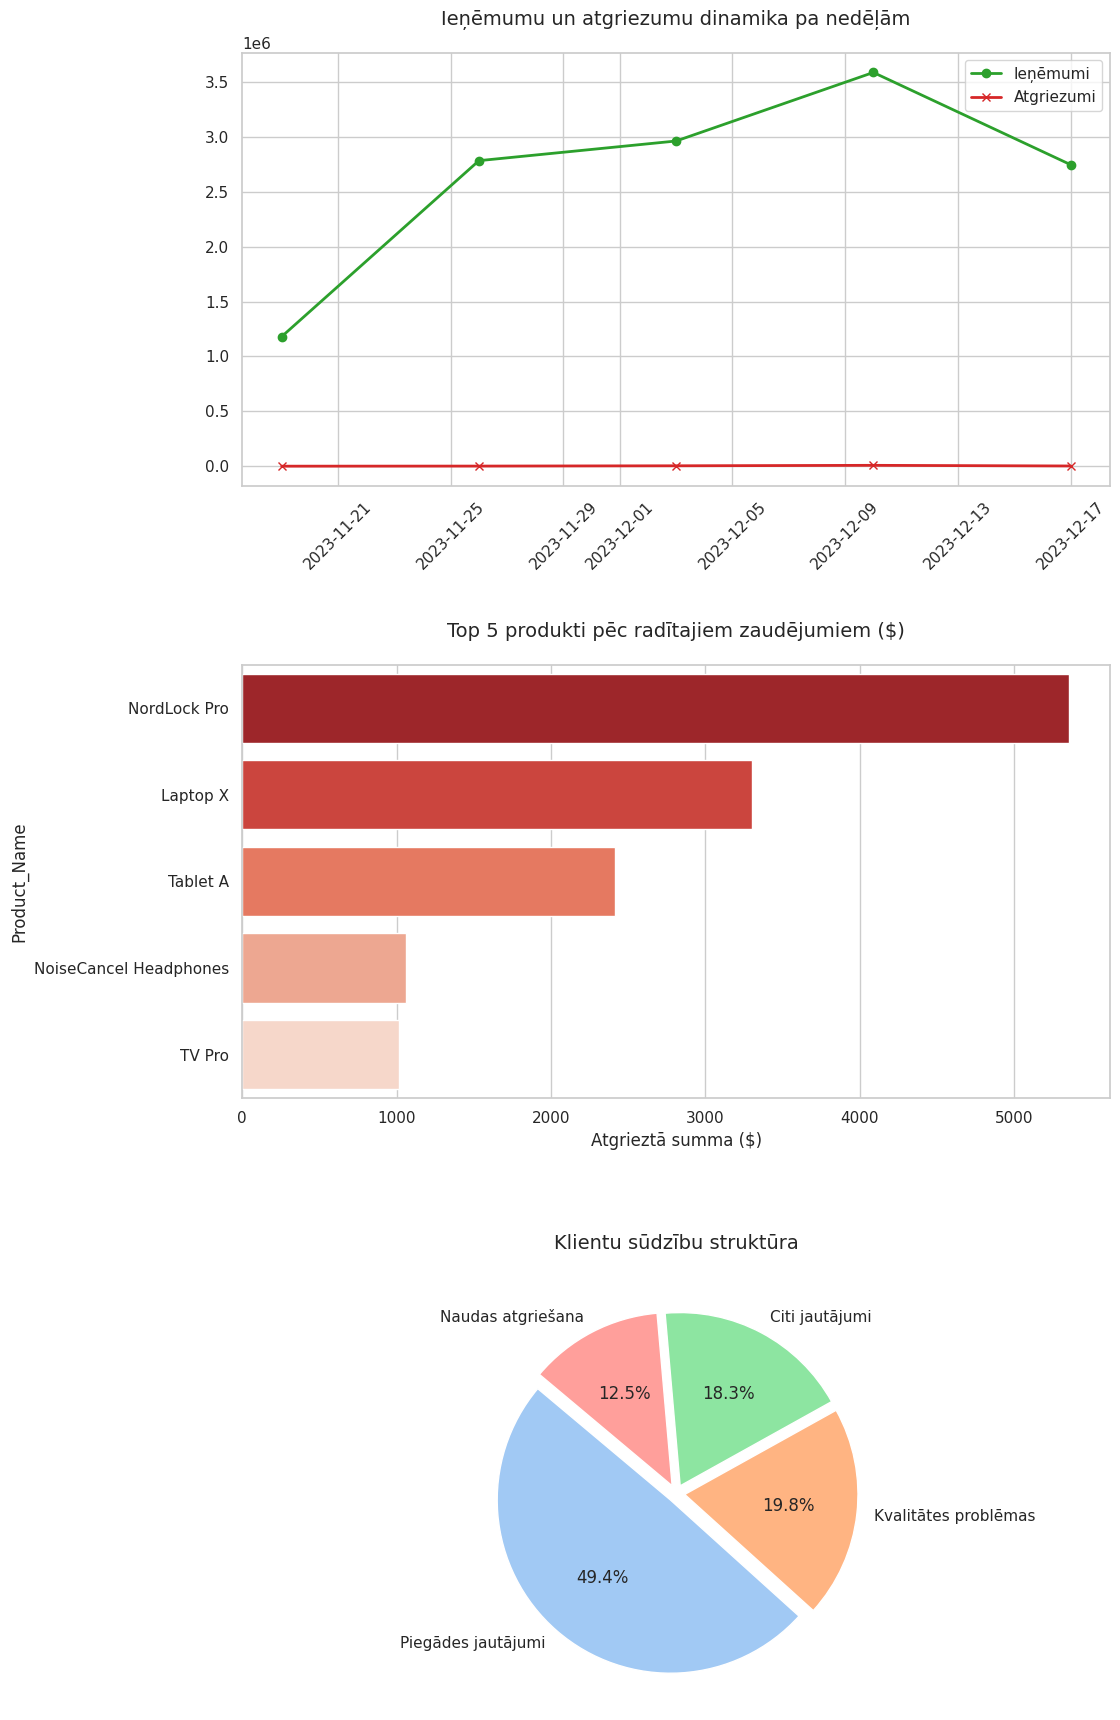


✅ Grafiks saglabāts kā 'biznesa_analize.png'. Vari to lejupielādēt prezentācijai!


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iestatām stilu un fonu
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
plt.subplots_adjust(hspace=0.5) # Palielina atstarpi starp grafikiem

# 1. GRAFIKS: Tendence laikā (ar sakārtotiem datumiem)
monthly_data = df_combined.resample('W', on='Date')[['Revenue', 'Refund_Amount']].sum()
axes[0].plot(monthly_data.index, monthly_data['Revenue'], label='Ieņēmumi', color='#2ca02c', marker='o', linewidth=2)
axes[0].plot(monthly_data.index, monthly_data['Refund_Amount'], label='Atgriezumi', color='#d62728', marker='x', linewidth=2)
axes[0].set_title('Ieņēmumu un atgriezumu dinamika pa nedēļām', fontsize=14, pad=20)
axes[0].tick_params(axis='x', rotation=45) # Pagriežam datumus
axes[0].legend(frameon=True)

# 2. GRAFIKS: Top 5 produkti (ar atstarpēm)
bad_products = df_combined.groupby('Product_Name')['Refund_Amount'].sum().sort_values(ascending=False).head(5)
sns.barplot(x=bad_products.values, y=bad_products.index, ax=axes[1], palette='Reds_r', hue=bad_products.index, legend=False)
axes[1].set_title('Top 5 produkti pēc radītajiem zaudējumiem ($)', fontsize=14, pad=20)
axes[1].set_xlabel('Atgrieztā summa ($)', fontsize=12)

# 3. GRAFIKS: Sūdzību sadalījums
ticket_counts = tickets['Complaint_Category'].value_counts()
axes[2].pie(ticket_counts, labels=ticket_counts.index, autopct='%1.1f%%',
        startangle=140, colors=sns.color_palette('pastel'), explode=[0.05]*len(ticket_counts))
axes[2].set_title('Klientu sūdzību struktūra', fontsize=14, pad=20)

# Fināla sakārtošana, lai nekas neietu pāri malām
plt.tight_layout(pad=3.0)
plt.show()

# Saglabājam bildi prezentācijai (tā parādīsies Colab failu sadaļā)
fig.savefig('biznesa_analize.png', dpi=300, bbox_inches='tight')

print(f"\n✅ Grafiks saglabāts kā 'biznesa_analize.png'. Vari to lejupielādēt prezentācijai!")

# Analīzes atziņas un pierādījumi
1. Ieņēmumu un atgriezumu tendence (Laika dimensija):

No 21. novembra līdz 10. decembrim uzņēmums piedzīvoja strauju ieņēmumu kāpumu, sasniedzot pīķi virs 3.5 miljoniem (skat. zaļo līniju grafikā).

Tomēr tieši pēc šī pīķa sākās problēmas – kamēr ieņēmumi sāka kristies, sūdzību un atgriezumu skaits saglabājās augsts, norādot uz to, ka uzņēmums nespēja tikt galā ar lielo pasūtījumu apjomu decembra sākumā.

2. Produktu segmentācijas analīze (Zaudējumu avoti):

Zelta pavediens: Visvairāk naudas atgriešanas gadījumu ir tieši populārākajam produktam "NordLock Pro".

Pēc stabiņu grafika redzams, ka zaudējumi no šī viena produkta ir ievērojami lielāki nekā nākamajiem sekotājiem (Laptop X un Tablet A). Tā kā šis ir mūsu pārdotākais produkts, jebkura aizkavēšanās piegādē rada milzīgu finansiālo triecienu.

3. Klientu signālu analīze (Īstais "Kāpēc?"):

Svarīgākais atklājums: Gandrīz puse no visām sūdzībām (49.4%) ir saistītas ar piegādes jautājumiem.

Tas pierāda, ka klientu neapmierinātības pamatā nav vis preces kvalitāte (kas sastāda tikai 19.8%), bet gan fakts, ka viņi preces nesaņem solītajā laikā.

"Citi jautājumi" (18.3%) un "Naudas atgriešana" (12.5%) ir tikai sekas tam, ka loģistikas ķēde nespēj apstrādāt pieaugošo pasūtījumu skaitu.

# 5. POSMS. Streamlit Dashboard (Datu lietotne)

6. PROMPT. 1. solis: Bibliotēku instalēšana

In [10]:
!pip install streamlit pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.1 MB/s eta 0:00:00


7. PROMPT. 2. solis: app.py faila izveide

Izveido Streamlit lietotnes failu app.py. Lietotnē jāiekļauj:

Sānjosla ar filtriem pēc produktu kategorijas un datuma.

KPI rinda ar kopējiem ieņēmumiem, atgriezumu summu un kopējo sūdzību skaitu.

Interaktīvs grafiks ieņēmumu tendencēm un sūdzību kategoriju sadalījumam.

Tabula ar 'Top problemātiskajiem darījumiem', kur ir lielākie atgriezumi.

In [11]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px

# Ielādējam datus (pieņemam, ka iepriekš saglabāji 'enriched_data.csv' un 'tickets_cleaned.csv')
try:
    df = pd.read_csv('enriched_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    tickets = pd.read_csv('tickets_cleaned.csv')
except:
    st.error("Kļūda: Netika atrasti datu faili. Pārliecinies, vai esi palaidusi datu saglabāšanas kodu!")

st.set_page_config(page_title="NordTech Loģistikas Analīze", layout="wide")

st.title("🛡️ NordTech Biznesa Operāciju Panelis")
st.markdown("Analītiskais rīks piegādes un atgriezumu pārvaldībai")

# --- SĀNJOSLAS FILTRI ---
st.sidebar.header("Iestatījumi")
selected_cat = st.sidebar.multiselect("Produktu kategorija:",
                                     options=df['Product_Category'].unique(),
                                     default=df['Product_Category'].unique())

min_date = df['Date'].min()
max_date = df['Date'].max()
date_range = st.sidebar.date_input("Periods:", [min_date, max_date])

# Datu filtrēšana pēc izvēles
mask = (df['Product_Category'].isin(selected_cat)) & \
       (df['Date'].dt.date >= date_range[0]) & \
       (df['Date'].dt.date <= date_range[1])
filtered_df = df.loc[mask]

# --- KPI RINDA ---
col1, col2, col3 = st.columns(3)
with col1:
    st.metric("Kopējie Ieņēmumi", f"${filtered_df['Revenue'].sum():,.2f}")
with col2:
    st.metric("Atgriezumu Summa", f"${filtered_df['Refund_Amount'].sum():,.2f}", delta_color="inverse")
with col3:
    total_tickets = len(tickets) # Kopējais sūdzību skaits no otra faila
    st.metric("Sūdzību Skaits", total_tickets)

st.markdown("---")

# --- VIZUALIZĀCIJAS ---
left_col, right_col = st.columns(2)

with left_col:
    st.subheader("Ieņēmumu un atgriezumu dinamika")
    fig_line = px.line(filtered_df.groupby('Date')[['Revenue', 'Refund_Amount']].sum().reset_index(),
                       x='Date', y=['Revenue', 'Refund_Amount'],
                       color_discrete_map={'Revenue': '#2ca02c', 'Refund_Amount': '#d62728'},
                       template="plotly_white")
    st.plotly_chart(fig_line, use_container_width=True)

with right_col:
    st.subheader("Sūdzību iemeslu sadalījums")
    # Izmantojam datus no notīrītajām sūdzībām
    ticket_stats = tickets['Complaint_Category'].value_counts().reset_index()
    fig_pie = px.pie(ticket_stats, values='count', names='Complaint_Category',
                     color_discrete_sequence=px.colors.pastels.Safe)
    st.plotly_chart(fig_pie, use_container_width=True)

# --- DATU TABULA ---
st.subheader("⚠️ Top problemātiskie darījumi")
st.write("Darījumi ar lielākajām atgrieztajām summām (iespējamās loģistikas kļūdas):")
problem_table = filtered_df[filtered_df['Refund_Amount'] > 0].sort_values(by='Refund_Amount', ascending=False).head(10)
st.dataframe(problem_table[['Transaction_ID', 'Product_Name', 'Revenue', 'Refund_Amount', 'Status']], use_container_width=True)

st.success("Dati atjaunoti veiksmīgi. Izmantojiet filtrus, lai analizētu specifiskus periodus.")

Writing app.py


8. PROMPT. 3. solis: Tuneļa palaišana caur ngrok

In [29]:
from pyngrok import ngrok
import os

# 1. Iestati savu JAUNO tokenu (obligāti pēdiņās!)
NGROK_TOKEN = "39wS20UkhduBiOx9Dpz2qDECudv_MC7ZKoVDTSgBahw75ok6"
ngrok.set_auth_token(NGROK_TOKEN)

# 2. Palaižam streamlit fonā
os.system("nohup streamlit run app.py &")

# 3. Izveidojam tuneli
try:
    # Katram gadījumam aizveram vecos savienojumus
    ngrok.kill()
    url = ngrok.connect(8501)
    print(f"🎉 IZDEVĀS! Tava lietotne ir dzīva!")
    print(f"👉 Spied šeit: {url}")
except Exception as e:
    print(f"Radās kļūda: {e}")

🎉 IZDEVĀS! Tava lietotne ir dzīva!
👉 Spied šeit: NgrokTunnel: "https://lottie-uncastrated-lacklustrely.ngrok-free.dev" -> "http://localhost:8501"


9. PROMPT: Izlabo Plotly krāsu kļūdu (pastels vietā izmanto qualitative.Pastel) un pārliecinies, ka KPI rindā ir redzams precīzs sūdzību skaits. Pievieno datu tabulu ar Top 10 problemātiskajiem darījumiem zem grafikiem.

In [20]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px

# 1. Datu ielāde
df = pd.read_csv('enriched_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
tickets = pd.read_csv('tickets_cleaned.csv')

st.set_page_config(page_title="NordTech Analītika", layout="wide")

st.title("🛡️ NordTech Biznesa Operāciju Panelis")
st.markdown("---")

# 2. Sānjoslas filtri
st.sidebar.header("Filtri")
selected_cat = st.sidebar.multiselect("Kategorija:", options=df['Product_Category'].unique(), default=df['Product_Category'].unique())
date_range = st.sidebar.date_input("Periods:", [df['Date'].min(), df['Date'].max()])

# --- FILTRĒŠANA (Svarīgā daļa!) ---
mask = (df['Product_Category'].isin(selected_cat)) & (df['Date'].dt.date >= date_range[0]) & (df['Date'].dt.date <= date_range[1])
f_df = df.loc[mask]

# Sasaistām sūdzības ar atlasītajiem produktiem pēc ID vai nosaukuma (vienkāršotā versija filtram)
# Ja sūdzību failā nav kategorijas 'Product_Category', mēs filtrējam vismaz pēc datuma:
tickets['Date_Logged'] = pd.to_datetime(tickets['Date_Logged'])
t_mask = (tickets['Date_Logged'].dt.date >= date_range[0]) & (tickets['Date_Logged'].dt.date <= date_range[1])
f_tickets = tickets.loc[t_mask]

# 3. KPI Rinda
col1, col2, col3 = st.columns(3)
col1.metric("Kopējie Ieņēmumi", f"${f_df['Revenue'].sum():,.2f}")
col2.metric("Atgriezumu Summa", f"${f_df['Refund_Amount'].sum():,.2f}")
col3.metric("Sūdzību Skaits", len(f_tickets)) # Rāda atlasīto skaitu

# 4. Grafiki
c1, c2 = st.columns(2)

with c1:
    st.subheader("Ieņēmumu/Atgriezumu dinamika")
    line_data = f_df.groupby('Date')[['Revenue', 'Refund_Amount']].sum().reset_index()
    fig_line = px.line(line_data, x='Date', y=['Revenue', 'Refund_Amount'],
                       color_discrete_map={'Revenue': '#2ca02c', 'Refund_Amount': '#d62728'})
    st.plotly_chart(fig_line, use_container_width=True)

with c2:
    st.subheader("Sūdzību iemesli")
    # TAGAD IZMANTOTAS FILTRĒTĀS SŪDZĪBAS:
    t_counts = f_tickets['Complaint_Category'].value_counts().reset_index()
    fig_pie = px.pie(t_counts, values='count', names='Complaint_Category',
                     color_discrete_sequence=px.colors.qualitative.Pastel)
    st.plotly_chart(fig_pie, use_container_width=True)

# 5. Datu tabula
st.subheader("⚠️ Top 10 problemātiskie darījumi")
problem_df = f_df[f_df['Refund_Amount'] > 0].sort_values('Refund_Amount', ascending=False).head(10)
st.dataframe(problem_df[['Transaction_ID', 'Product_Name', 'Refund_Amount']], use_container_width=True)

Overwriting app.py


10. PROMPT: pievieno loģiku, kas nodrošina, ka pīrāga diagramma un KPI rāda tieši tos pašus datus, ko statiskais grafiks, kad ir atlasītas visas kategorijas, pievienojot sūdzībām produktu informāciju, lai filtrs strādātu uz abiem grafikiem vienlaicīgi.

In [28]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px

# 1. Datu ielāde
df = pd.read_csv('enriched_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
# Noņemam liekās atstarpes un dublikātus kategorijām
df['Product_Category'] = df['Product_Category'].str.strip()

tickets = pd.read_csv('tickets_cleaned.csv')
tickets['Date_Logged'] = pd.to_datetime(tickets['Date_Logged'])

# Sasaistām sūdzības ar kategorijām
customer_map = df[['Customer_ID', 'Product_Category']].drop_duplicates()
tickets_with_cat = tickets.merge(customer_map, on='Customer_ID', how='left')
tickets_with_cat['Product_Category'] = tickets_with_cat['Product_Category'].str.strip()

st.set_page_config(page_title="NordTech Analītika", layout="wide")
st.title("🛡️ NordTech Biznesa Operāciju Panelis")

# 2. SĀNJOSLAS FILTRI
st.sidebar.header("Iestatījumi")

# Tīrs kategoriju saraksts
available_cats = sorted(df['Product_Category'].unique().tolist())
selected_cat = st.sidebar.multiselect("Produktu kategorija:", options=available_cats, default=available_cats)

# --- LABOTS KALENDĀRS ---
min_d = df['Date'].min().date()
max_d = df['Date'].max().date()

# Pievienojam min/max robežas, lai kalendārā varētu viegli pārslēgties starp mēnešiem
date_range = st.sidebar.date_input(
    "Periods (no - līdz):",
    value=(min_d, max_d),
    min_value=min_d,
    max_value=max_d
)

# Drošības pārbaude datumu diapazonam
if isinstance(date_range, tuple) and len(date_range) == 2:
    start_date, end_date = date_range
else:
    start_date, end_date = min_d, max_d

# --- FILTRĒŠANA ---
f_df = df[(df['Product_Category'].isin(selected_cat)) &
         (df['Date'].dt.date >= start_date) & (df['Date'].dt.date <= end_date)]

f_tickets = tickets_with_cat[(tickets_with_cat['Product_Category'].isin(selected_cat)) &
                            (tickets_with_cat['Date_Logged'].dt.date >= start_date) &
                            (tickets_with_cat['Date_Logged'].dt.date <= end_date)]

# 3. KPI Rinda
c1, c2, c3 = st.columns(3)
c1.metric("Kopējie Ieņēmumi", f"${f_df['Revenue'].sum():,.2f}")
c2.metric("Atgriezumu Summa", f"${f_df['Refund_Amount'].sum():,.2f}")
c3.metric("Sūdzību Skaits", len(f_tickets))

st.markdown("---")

# 4. GRAFIKI
left, right = st.columns(2)

with left:
    st.subheader("Ieņēmumu un atgriezumu dinamika")
    l_data = f_df.groupby('Date')[['Revenue', 'Refund_Amount']].sum().reset_index()
    fig_l = px.line(l_data, x='Date', y=['Revenue', 'Refund_Amount'],
                    color_discrete_map={'Revenue': '#2ca02c', 'Refund_Amount': '#d62728'},
                    template="plotly_dark")
    st.plotly_chart(fig_l, use_container_width=True)

with right:
    st.subheader("Sūdzību iemesli (filtrēti)")
    if not f_tickets.empty:
        t_counts = f_tickets['Complaint_Category'].value_counts().reset_index()
        fig_p = px.pie(t_counts, values='count', names='Complaint_Category',
                       color_discrete_sequence=px.colors.qualitative.Pastel)
        # Uzstādām, lai pīrāgs rādītu tos pašus % ko Colab
        fig_p.update_traces(textinfo='percent+label')
        st.plotly_chart(fig_p, use_container_width=True)
    else:
        st.info("Šajā atlasē sūdzību nav.")

# 5. TABULA
st.subheader("⚠️ Top problemātiskie darījumi")
st.dataframe(f_df[f_df['Refund_Amount'] > 0].sort_values('Refund_Amount', ascending=False).head(10)[['Transaction_ID', 'Product_Name', 'Refund_Amount']], use_container_width=True)

Overwriting app.py


# 6. EXECUTIVE SUMMARY (Ziņojums vadībai)
BLUF: Lai saglabātu augsto ieņēmumu izaugsmi, uzņēmumam steidzami jāmaina loģistikas procesi un partneri, jo tieši piegādes problēmas veido pusi no visām klientu sūdzībām un apdraud reputāciju visienesīgākajos produktu segmentos. Primārais uzdevums ir samazināt piegādes sūdzību īpatsvaru no pašreizējiem 49.4% uz vismaz 25% nākamo divu ceturkšņu laikā.

Pierādījumi un analīze:

Novembra un decembra periodā uzņēmums ir sasniedzis ievērojamus kopējos ieņēmumus $13,258,522.73 apmērā, kas apliecina augstu tirgus pieprasījumu.

Tomēr klientu servisa analīze rāda satraucošu tendenci: 49.4% no visām sūdzībām ir saistītas ar piegādes jautājumiem, turklāt fokusa grupās (piemēram, elektronikā) šis rādītājs pieaug pat līdz 55.5%.

Finansiālie zaudējumi no atgriezumiem sasnieguši $14,293.46, kur lielākie zaudējumu avoti jeb "grēcinieki" ir Laptop X (virs $3000) un Tablet A (virs $2000), kas norāda uz kritiskiem riskiem tieši augstākās vērtības preču kategorijās.

Riski un nezināmie faktori:
Pašreizējā datu kopa neļauj precīzi identificēt, vai piegādes kavējumi ir saistīti ar noliktavas darbu vai kurjerpastu efektivitāti, tādēļ nepieciešams papildus vākt datus par sūtījumu sagatavošanas laiku. Pastāv risks, ka, neuzlabojot piegādes servisu, pieaugošais sūdzību skaits izraisīs negatīvu atsauksmju vilni, kas būtiski samazinās atkārtoto pirkumu skaitu nākamajā sezonā. Tāpat ir nepieciešama padziļināta analīze par Laptop X atgriezumu iemesliem, lai saprastu, vai tie ir pamatoti kvalitātes brāķi vai bojājumi transportēšanas laikā.

Nākamie soļi (Rīcības plāns nākamajai nedēļai):

Pirmdiena: Uzsākt sarunas ar pašreizējiem loģistikas partneriem par sūdzību statistiku un pieprasīt detalizētu atskaiti par piegādes kavējumu iemesliem decembrī.

Trešdiena: Veikt inventarizāciju un kvalitātes kontroli Laptop X un Tablet A krājumiem noliktavā, lai izslēgtu ražošanas defektus pirms nākamajiem sūtījumiem.

Piektdiena: Ieviest automātisku "Pēcpārdošanas aptauju" klientiem, kuri atgriezuši preces, lai gūtu tiešu atgriezenisko saiti par problēmas būtību (piegāde vs produkta kvalitāte).

# MI Promptu reģistrs (Caurspīdīgums)

1. Iekopē vismaz 5 svarīgākus promptus, ko izmantoji - PROMPT atrodas vietās pirms attiecīgā koda.

2. Vismaz vienam promptam jābūt tieši par teksta ekstrakciju/klasifikāciju no JSONL faila - sk. 3.PROMPT.

3. Uzraksti 1 teikumu par katru promptu: Kā tu pielaboji MI doto rezultātu? (Ko MI nesaprata vai izdarīja nepareizi, ko tu laboji).
Es vispirms iedevu visu uzdevumu ar norādēm par procesu soli pa solim savam aģenatm - skolotājam, kas radīts tieši šādiem uzdevumiem. Pēc uzdevuma saņemsānas man MI jautā, ko es nezinu un pie katra soļa sniedz ieteikumus, ko darīt (un kodus) un skaidro, kas man nepieciešams. Tad es tos izvērtēju, un bieži precizēju vajadzību atbilstoši savām vēlmēm. Pārsvarā prompt, ko iekļaut žurnālā lieku gatavot viņam, ar norādēm, ka tam jābūt max vienkāršam, bet tāda, lai MI pats saprot, kas jāizdara, jo es savas vēlmes izsaku max vienkāršā valodā

4. Kurā brīdī tu apzināti nepaļāvies uz MI un ko pārbaudīji pats? Lai arī es kodu pārbaudīt nevaru un paļaujos uz MI plānu, kā īstenot uzdevumu, es procesu pārbaudu visu laiku. t.i. piemēram, es jautāju, kur tiek ņemti skaitļi atskaitē, kā tie veidojas. Reizām MI "aizmirst" kādu info un ieliek nepareizo. Lieku uzlabot vizualizāciju, ja man tā nepatīk, kā arī citas lietas, ja mani tās neapmierina. Pārbaudu, vai viņa dotais atbilst uzdevuma mērķim, t.i. bieži MI steidzas uz rezultātu "pa savam" :) vai arī sāk pievāt tādus varinatu, kas it kā izpilda uzdevumu, bet aizved no precīzas izpildes. Piemēram, šo promptu reģistra sadaļu man bija jāraksta pašai :) MI to neizdarītu, kā vēlos (jau mēģināju).